# Tube Diameter effect on Plug Flow Reactors

##### Author: Franz Navarro ([CAChemE.org](http://CAChemE.org)) 
##### Copyright: Text and images CC-BY / Code MIT - Original source [LearnChemE](http://demonstrations.wolfram.com/EffectOfTubeDiameterOnPlugFlowReactor/)

This IPython notebook shows the effect of tube diameter on conversion, temperature, and pressure drop for a plug flow reactor (PFR). The original example came from [this LearnChemE.com simulation](http://demonstrations.wolfram.com/EffectOfTubeDiameterOnPlugFlowReactor/). Specifically, a first-order exothermic reaction takes place in a PFR accounting for the pressure drop and heat transfer through the walls. The user can vary the reactor diameter keeping total feed flow rate constant (by changing the number of parallel reactors, named as "# equivalent reactors"). Thus, the total reactor cross section remains constant as it does its (total) molar feed flow rate.

Notice that, for smaller-diameter reactors, the pressure drop is higher since the volumetric flow rate increases and the residence time is reduced (lowering the conversion). Besides, heat transfer is more efficient for smaller-diameter reactors because the surface area per volume is larger which allow better reaction control. In this simple case, the temperature increases less in the reactor, and this also lowers conversion. The physics being modeled here are the fundamentals of [Microreactors](http://en.wikipedia.org/wiki/Microreactor).

<div class="alert alert-warning" role="alert" style="margin: 10px">[IPython](http://ipython.org/) provides a rich architecture for interactive computing as Mathematica or MATLAB do, but Python is open-source and completely free (instead of propietary and expensive software). If you want to run this notebook in your computer we recommend [Anaconda with Python 3](http://continuum.io/downloads#py34).</div>


In [1]:
# Loading our favorite python libraries

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.style.use('bmh')

# The following code will only work in Python 3 since we will be using unicode characteres

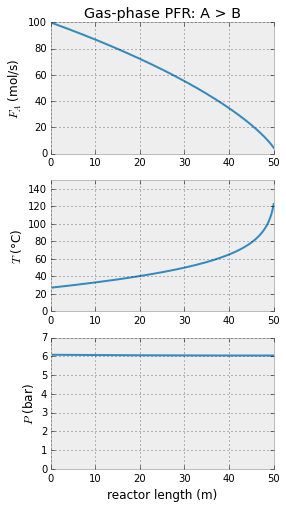

In [2]:
""" Plug flow reactor model
Gas-phase A --> B
"""
# Reactor parameters
diameter = 0.3  # [m] Diameter of the tube reactor
diameter_0 = 0.3  # [m] Diameter of the initial tube reactor being studied
length = 50  # [m] Length of the tube reactor

A_cross = np.pi/4*diameter**2  # [m^2]  Cross sectional aera of the tube reactor
A_cross_0 = np.pi/4*diameter_0**2  # [m^2]  Cross sectional aera of the tube reactor

number_reactors = A_cross_0 / A_cross  # equivalent reactors to keep same area and flow rate

# Operating conditions
FA_0 =  100  # [mol m^{-3}] inlet molar flow rate 
FA_0_n = 100/number_reactors # [mol m^{-3}] inlet molar flow rate within one reactor

P_0 = 6.08e5  # [Pa] Pressure inlet
T_0 = 300  # [K] Temperature inlet


def diffEqs(y, z, FA_0_n, T_0, P_0, A_cross):
    ''' y is a vector with the concentration
    z is the indpendt variable (time)
    '''
    
    FA_z = y[0]  # [mol] molar flow (dependent variable)
    T_z  = y[1]  # [K] temperature (dependent variable)
    P_z  = y[2]  # [Pa] pressure (dependent variable)
    
    # Constants
    # ---------
    R_const = 8.314  # [m^{3} Pa K^{−1} mol^{−1}]
    
    ρ = 230     # [kg m^{-3}] fluid density (average)
    μ = 2.3e-5  # [kg m^{-1} s^{-1}] dynamics viscosity (average)
    
    ϵ = 45e-6  # [m] wall roughness

    ΔH = -25000   # [J mol^{-1}] heat of reaction
    Cp = 550      # [J mol^{-1} K^{-1}] heat capacity of reactants (average)
    Ua = 500      # [J m^{-3} s^{-1} K^{-1}] heat transfer coefficient times area/volume
    T_cool = 300  # [K] Cooling temperature inlet
    
    # Lenght dependent parameters
    # ---------------------------
    
    vol_flow_0 = (FA_0_n * R_const * T_0) /  P_0  # [m^3/s] inlet gas velocity
    vol_flow = vol_flow_0 * FA_z/FA_0_n * P_0/P_z* T_z/T_0  # [m^3/s] volumetric flow

    
    # Mass balance
    # ------------
    Afactor = 0.0715  # [s^{-1}] pre-exponential factor
    Ea = 17000  # activation energy

    T_m = 300   # [K] Temperature 
    
    k = Afactor * np.exp(-Ea/R_const * (1/T_z - 1/T_m))  # [s^{-1}]reaction rate
    CA_z = FA_z/vol_flow  # [mol/s] molar flow rate
    
    dFdz = -k * CA_z * A_cross # first-order exothermic reaction
    
    # Energy Balance
    # --------------
    dTdz = (Ua*(T_cool-T_z) - k*CA_z*A_cross*ΔH) / (FA_z * Cp)
    
    # Pressure drop
    # --------------
    NRe = (ρ * vol_flow/A_cross * diameter) / μ  # [-] Reynolds number

    if NRe <= 2300:
        f_factor = 64/NRe
    elif NRe > 2300:
        f_factor = 0.25 * np.log10(ϵ/(3.7*diameter) +  5.74/NRe**0.9)**-2
        
    dPdz = -ρ * f_factor/diameter * ((vol_flow/A_cross)**2/2)


    return [dFdz, dTdz, dPdz]


z  = np.linspace(0., length, 1000)

y0 = [FA_0_n, T_0, P_0] # [molar flow, temperature, pressure]

# We call the ode in order to intregate
Y = odeint(diffEqs, y0, z, args=(FA_0_n, T_0, P_0, A_cross))

# Taking back the solutions
F_A = Y[:, 0] # mol*L-1
T   = Y[:, 1] # mol*L-1
P   = Y[:, 2] # mol*L-1

F_A_total = F_A * number_reactors
T_Celsius= T - 273.15  # [K]->[ºC] Conversion of temperature
P_bar =  P/1e5  # [Pa]->[bar] conversion of pressure

conversion = (1 - F_A[-1]/F_A[0]) * 100  # for the B component

# Plotting results
# -------------------
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,
                                    figsize=(4,8))
# Molar flow alongside the reactor
ax1.plot(z, F_A_total)
# ax1.set_xlabel("reactor length (m)")
ax1.set_ylabel("$F_{A}$ (mol/s)")
ax1.set_title("Gas-phase PFR: A > B")

ax1.set_xlim([0,50])
ax1.set_ylim([0,100])

# Temperature alongside the reactor
ax2.plot(z, T_Celsius)
# ax2.set_xlabel("reactor length (m)")
ax2.set_ylabel("$T$ (°C)")
# ax2.set_title("Evolution of the temperature within the PFR")
ax2.set_xlim([0,50])
ax2.set_ylim([0,150])

# Pressure alongside the reactor
ax3.plot(z, P_bar)
ax3.set_xlabel("reactor length (m)")
ax3.set_ylabel("$P$ (bar)")
# ax3.set_title("Evolution of the pressure within the PFR")
ax3.set_xlim([0,50])
ax3.set_ylim([0,7])

plt.show()

The code works like a charm! You can check that the results variate if we hand change the value of the diameter. But we want to add some interactivity as the orginal. So first let's wrap the code from above within a function:

In [3]:
def gasPFR(diameter=0.3):
    """ Plug flow reactor model
    For a simple gas-phase A --> B

    input arguments:
        diameter   [m] Diameter of the tube

    returns a plot with the mass, heat and moment Diff. eqs. solved
    """
    # Reactor parameters
    diameter_0 = 0.3  # [m] Diameter of the initial tube reactor being studied
    length = 50  # [m] Length of the tube reactor

    A_cross = np.pi/4*diameter**2  # [m^2]  Cross sectional aera of the tube reactor
    A_cross_0 = np.pi/4*diameter_0**2  # [m^2]  Cross sectional aera of the tube reactor

    number_reactors = A_cross_0 / A_cross  # equivalent reactors to keep same area and flow rate

    # Operating conditions
    FA_0 =  100  # [mol m^{-3}] inlet molar flow rate 
    FA_0_n = 100/number_reactors # [mol m^{-3}] inlet molar flow rate within one reactor

    P_0 = 6.08e5  # [Pa] Pressure inlet
    T_0 = 300  # [K] Temperature inlet


    def diffEqs(y, z, FA_0_n, T_0, P_0, A_cross):
        ''' y is a vector with the concentration
        z is the indpendt variable (time)
        '''

        FA_z = y[0]  # [mol] molar flow (dependent variable)
        T_z  = y[1]  # [K] temperature (dependent variable)
        P_z  = y[2]  # [Pa] pressure (dependent variable)

        # Constants
        # ---------
        R_const = 8.314  # [m^{3} Pa K^{−1} mol^{−1}]

        ρ = 230     # [kg m^{-3}] fluid density (average)
        μ = 2.3e-5  # [kg m^{-1} s^{-1}] dynamics viscosity (average)

        ϵ = 45e-6  # [m] wall roughness

        ΔH = -25000   # [J mol^{-1}] heat of reaction
        Cp = 550      # [J mol^{-1} K^{-1}] heat capacity of reactants (average)
        Ua = 500      # [J m^{-3} s^{-1} K^{-1}] heat transfer coefficient times area/volume
        T_cool = 300  # [K] Cooling temperature inlet

        # Lenght dependent parameters
        # ---------------------------

        vol_flow_0 = (FA_0_n * R_const * T_0) /  P_0  # [m^3/s] inlet gas velocity
        vol_flow = vol_flow_0 * FA_z/FA_0_n * P_0/P_z* T_z/T_0  # [m^3/s] volumetric flow


        # Mass balance
        # ------------
        Afactor = 0.0715  # [s^{-1}] pre-exponential factor
        Ea = 17000  # activation energy

        T_m = 300   # [K] Temperature 

        k = Afactor * np.exp(-Ea/R_const * (1/T_z - 1/T_m))  # [s^{-1}]reaction rate
        CA_z = FA_z/vol_flow  # [mol/s] molar flow rate

        dFdz = -k * CA_z * A_cross # first-order exothermic reaction

        # Energy Balance
        # --------------
        dTdz = (Ua*(T_cool-T_z) - k*CA_z*A_cross*ΔH) / (FA_z * Cp)

        # Pressure drop
        # --------------
        NRe = (ρ * vol_flow/A_cross * diameter) / μ  # [-] Reynolds number

        if NRe <= 2300:
            f_factor = 64/NRe
        elif NRe > 2300:
            f_factor = 0.25 * np.log10(ϵ/(3.7*diameter) +  5.74/NRe**0.9)**-2

        dPdz = -ρ * f_factor/diameter * ((vol_flow/A_cross)**2/2)


        return [dFdz, dTdz, dPdz]


    z  = np.linspace(0., length, 1000)

    y0 = [FA_0_n, T_0, P_0] # [molar flow, temperature, pressure]

    # We call the ode in order to intregate
    Y = odeint(diffEqs, y0, z, args=(FA_0_n, T_0, P_0, A_cross))

    # Taking back the solutions
    F_A = Y[:, 0] # mol*L-1
    T   = Y[:, 1] # mol*L-1
    P   = Y[:, 2] # mol*L-1

    F_A_total = F_A * number_reactors
    T_Celsius= T - 273.15  # [K]->[ºC] Conversion of temperature
    P_bar =  P/1e5  # [Pa]->[bar] conversion of pressure

    conversion = (1 - F_A[-1]/F_A[0]) * 100  # for the B component

    # Plotting results
    # -------------------
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,
                                        figsize=(4,8))
    # Molar flow alongside the reactor
    ax1.plot(z, F_A_total)
    # ax1.set_xlabel("reactor length (m)")
    ax1.set_ylabel("$F_{A}$ (mol/s)")
    ax1.set_title("Gas-phase PFR: A > B")

    ax1.set_xlim([0,50])
    ax1.set_ylim([0,100])

    # Temperature alongside the reactor
    ax2.plot(z, T_Celsius)
    # ax2.set_xlabel("reactor length (m)")
    ax2.set_ylabel("$T$ (°C)")
    # ax2.set_title("Evolution of the temperature within the PFR")
    ax2.set_xlim([0,50])
    ax2.set_ylim([0,150])

    # Pressure alongside the reactor
    ax3.plot(z, P_bar)
    ax3.set_xlabel("reactor length (m)")
    ax3.set_ylabel("$P$ (bar)")
    # ax3.set_title("Evolution of the pressure within the PFR")
    ax3.set_xlim([0,50])
    ax3.set_ylim([0,7])

    plt.show()

Done! Let's test the function with different arguments:


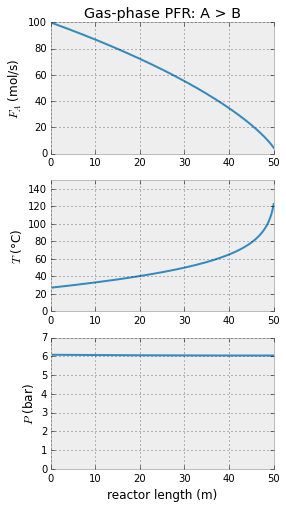

In [4]:
gasPFR(0.3) # diameter of the reactor will be 0.3 m

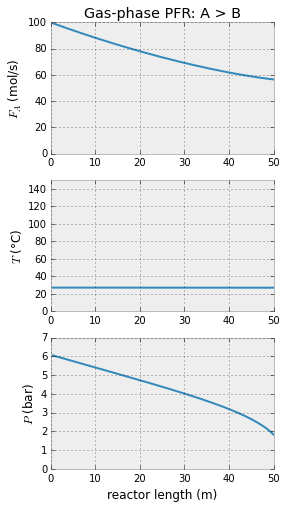

In [5]:
gasPFR(0.015) # diameter of the reactor will be now 1.5 cm

Look at that! The results reproduce the phyisics under study. In our last example we have a tiny reactor with a diameter of just 1.5 cm. As you can see, now the pressure loss is significant but the temperature remains almost constant. 

## Making an interactive plot

Time for the magic of IPython Notebook! We will rearrange some code and use the interactivy of IPython, but this is just for showing off don't be scared if this is your first time reading Python code. The vary basic idea is to use the function we just wrote above and call the awesome widgets of IPython.

In [6]:
from IPython.html.widgets import interact
from matplotlib.patches import Ellipse, Rectangle, Arrow

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [12]:
def interactive_PFR(diameter=0.3):
    """ Plug flow reactor model
    For a simple gas-phase A --> B

    input arguments:
        diameter   [m] Diameter of the tube

    returns a plot with the mass, heat and moment Diff. eqs. solved
    """
    # Reactor parameters
    diameter_0 = 0.3  # [m] Diameter of the initial tube reactor being studied
    length = 50  # [m] Length of the tube reactor

    A_cross = np.pi/4*diameter**2  # [m^2]  Cross sectional aera of the tube reactor
    A_cross_0 = np.pi/4*diameter_0**2  # [m^2]  Cross sectional aera of the tube reactor

    number_reactors = A_cross_0 / A_cross  # equivalent reactors to keep same area and flow rate

    # Operating conditions
    FA_0 =  100  # [mol m^{-3}] inlet molar flow rate 
    FA_0_n = 100/number_reactors # [mol m^{-3}] inlet molar flow rate within one reactor

    P_0 = 6.08e5  # [Pa] Pressure inlet
    T_0 = 300  # [K] Temperature inlet


    def diffEqs(y, z, FA_0_n, T_0, P_0, A_cross):
        ''' y is a vector with the concentration
        z is the indpendt variable (time)
        '''

        FA_z = y[0]  # [mol] molar flow (dependent variable)
        T_z  = y[1]  # [K] temperature (dependent variable)
        P_z  = y[2]  # [Pa] pressure (dependent variable)

        # Constants
        # ---------
        R_const = 8.314  # [m^{3} Pa K^{−1} mol^{−1}]

        ρ = 230     # [kg m^{-3}] fluid density (average)
        μ = 2.3e-5  # [kg m^{-1} s^{-1}] dynamics viscosity (average)

        ϵ = 45e-6  # [m] wall roughness

        ΔH = -25000   # [J mol^{-1}] heat of reaction
        Cp = 550      # [J mol^{-1} K^{-1}] heat capacity of reactants (average)
        Ua = 500      # [J m^{-3} s^{-1} K^{-1}] heat transfer coefficient times area/volume
        T_cool = 300  # [K] Cooling temperature inlet

        # Lenght dependent parameters
        # ---------------------------

        vol_flow_0 = (FA_0_n * R_const * T_0) /  P_0  # [m^3/s] inlet gas velocity
        vol_flow = vol_flow_0 * FA_z/FA_0_n * P_0/P_z* T_z/T_0  # [m^3/s] volumetric flow


        # Mass balance
        # ------------
        Afactor = 0.0715  # [s^{-1}] pre-exponential factor
        Ea = 17000  # activation energy

        T_m = 300   # [K] Temperature 

        k = Afactor * np.exp(-Ea/R_const * (1/T_z - 1/T_m))  # [s^{-1}]reaction rate
        CA_z = FA_z/vol_flow  # [mol/s] molar flow rate

        dFdz = -k * CA_z * A_cross # first-order exothermic reaction

        # Energy Balance
        # --------------
        dTdz = (Ua*(T_cool-T_z) - k*CA_z*A_cross*ΔH) / (FA_z * Cp)

        # Pressure drop
        # --------------
        NRe = (ρ * vol_flow/A_cross * diameter) / μ  # [-] Reynolds number

        if NRe <= 2300:
            f_factor = 64/NRe
        elif NRe > 2300:
            f_factor = 0.25 * np.log10(ϵ/(3.7*diameter) +  5.74/NRe**0.9)**-2

        dPdz = -ρ * f_factor/diameter * ((vol_flow/A_cross)**2/2)


        return [dFdz, dTdz, dPdz]


    z  = np.linspace(0., length, 1000)

    y0 = [FA_0_n, T_0, P_0] # [molar flow, temperature, pressure]

    # We call the ode in order to intregate
    Y = odeint(diffEqs, y0, z, args=(FA_0_n, T_0, P_0, A_cross))

    # Taking back the solutions
    F_A = Y[:, 0] # mol*L-1
    T   = Y[:, 1] # mol*L-1
    P   = Y[:, 2] # mol*L-1

    F_A_total = F_A * number_reactors
    T_Celsius= T - 273.15  # [K]->[ºC] Conversion of temperature
    P_bar =  P/1e5  # [Pa]->[bar] conversion of pressure

    conversion = (1 - F_A[-1]/F_A[0]) * 100  # for the B component

    # Plotting results
    # -------------------
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                        figsize=(10,10))
    # Molar flow alongside the reactor
    ax1.plot(z, F_A_total)
    ax1.set_xlabel("reactor length (m)")
    ax1.set_ylabel("$F_{A}$ (mol/s)")
    ax1.set_title("Gas-phase PFR: A > B")

    ax1.set_xlim([0,50])
    ax1.set_ylim([0,100])
    
    # Original code taken from:
    # https://gist.github.com/franktoffel/843e58486fea9d795400#file-plot_pfr-py

    reactor_length = 10    # [for graphing porposes]
    reactor_diameter = diameter*10  # [for graphing porposes] 

    arrow_lenght = 3  # [units]

    # Let's begin with the arrow representing the outlet
    arrow_outlet = Arrow(reactor_length, reactor_diameter/2,  # x, y (coordinates)
                         arrow_lenght, 0, width=0.1,          # dx, dy
                         facecolor="black")                   # color options
    ax2.add_patch(arrow_outlet)  # adds the path to the plot

    # Now we create and plot elliplse representing the end of the cillinder
    ellipse_outlet = Ellipse((reactor_length,reactor_diameter/2),   # x, y (coordinates)
                              reactor_diameter/2, reactor_diameter, # width, height
                              facecolor="grey", edgecolor="black")  # color options
    ax2.add_patch(ellipse_outlet)  # adds the patch to the plot

    # Create and plot the tube as rectangle 
    rectangle = Rectangle((0, 0),                            # x, y (coordinates)
                         reactor_length, reactor_diameter,   # width, height 
                         facecolor="grey", edgecolor="none") # color options 
    ax2.add_patch(rectangle)  # adds the patch to the plot

    # Again we create an ellipse but this time at the inlet
    ellipse_inlet = Ellipse((0,reactor_diameter/2),                # x, y (coordinates)
                            reactor_diameter/2, reactor_diameter,  # width, height
                            facecolor="grey", edgecolor="black")   # color options
    ax2.add_patch(ellipse_inlet) # adds the patch to the plot

    # And finally the inlet arrow
    arrow_inlet = Arrow(-arrow_lenght, reactor_diameter/2,  # x, y (coordinates)
                         arrow_lenght, 0, width=0.1,        # dx, dy 
                         facecolor="black")                 # color options
    ax2.add_patch(arrow_inlet)  # adds the patch to the plot

    ax2.set_xlim([-5,15])  # fixes the x axes
    ax2.set_ylim([-1,4])  # fixes the y axes

    # Temperature alongside the reactor
    ax3.plot(z, T_Celsius)
    ax3.set_xlabel("reactor length (m)")
    ax3.set_ylabel("$T$ (°C)")
    ax3.set_title("Evolution of the temperature")
    ax3.set_xlim([0,50])
    ax3.set_ylim([0,150])

    # Pressure alongside the reactor
    ax4.plot(z, P_bar)
    ax4.set_xlabel("reactor length (m)")
    ax4.set_ylabel("$P$ (bar)")
    ax4.set_title("Evolution of the pressure")
    ax4.set_xlim([0,50])
    ax4.set_ylim([0,7])

    plt.show()

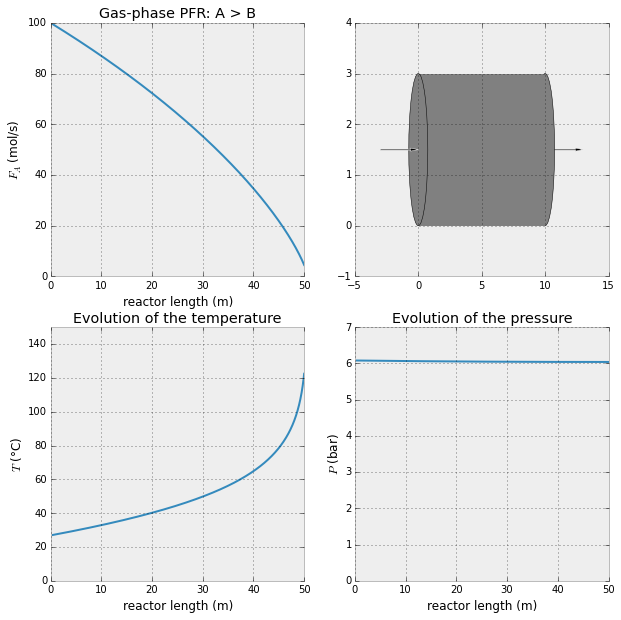

In [13]:
interactive_PFR(0.3)